# Mappings

Using mappings allows for easy reuse of pulse instances without the need for creating new pulses every time some part of the pulse changes. You can remap parameters, measurements, and channels. The mapping is passed to the `MappingPT` constructor as a dictionary whose keys are the old and whose values are the new items. In the following we will have a look at three short examples explaining the different mappings. Of course, they can also be combined.

If you haven't familiarized yourself with the concept of mappings, you can do so [here](05MappingTemplate.ipynb).

## Example 1: Parameter Mapping

Consider a simple `PointPT` pulse which may in practice be some elaborate pulse with many parameters but in this case simply jumps to the points of a triangle in the xy-plane:

<IPython.core.display.Javascript object>


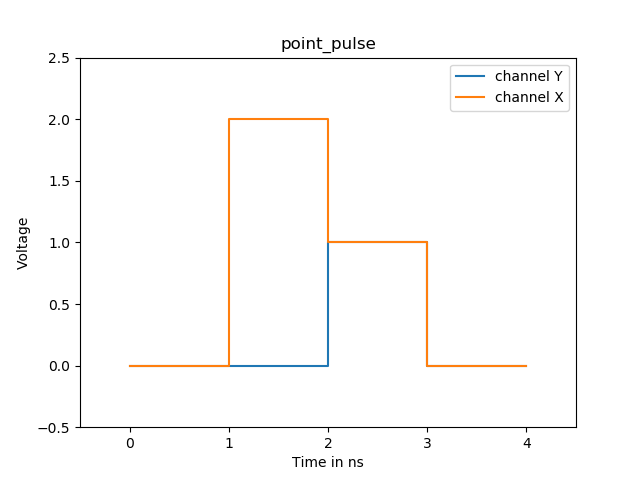

<IPython.core.display.Javascript object>


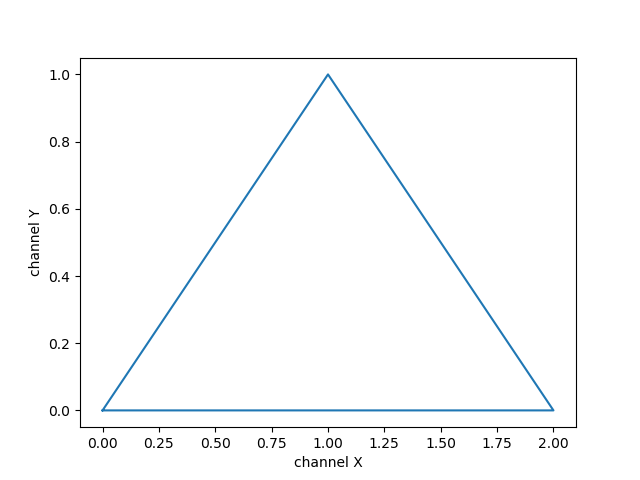

Text(0,0.5,'channel Y')

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from qctoolkit.pulses import PointPT
from qctoolkit.pulses.sequencing import Sequencer
from qctoolkit.pulses.plotting import plot, render

point_pulse = PointPT(
    time_point_tuple_list=[('t_1', 'v_1'),
                           ('t_2', 'v_1 + v_2', 'jump'),
                           ('t_3', 'v_1 + v_3', 'jump'),
                           ('t_4', 'v_1 + v_4', 'jump')],
    channel_names=('X', 'Y'),
    identifier='point_pulse'
)

params = {
    't_1': 1,
    't_2': 2,
    't_3': 3,
    't_4': 4,
    'v_1': np.array([0, 0]),
    'v_2': np.array([2, 0]),
    'v_3': np.array([1, 1]),
    'v_4': np.array([0, 0]),
}

_ = plot(point_pulse, params, sample_rate=100)

# Plot the pulse in 2d
sequencer = Sequencer()
sequencer.push(point_pulse, params)
sequence = sequencer.build()
times, voltages = render(sequence, sample_rate=100)

fig, ax = plt.subplots()
ax.plot(voltages['X'], voltages['Y'])
ax.set_xlabel('channel X')
ax.set_ylabel('channel Y')

Notice how `point_pulse` has four parameters that are vectors instead of scalars. That is, we give qctoolkit a `numpy.ndarray` with one value for channel X and one value with channel Y.

We now want to loop `point_pulse` and in each iteration move the starting point to some other value in the XY-plane by using two `ForLoopPT`s, one that moves the pulse in X-direction and one that moves it in Y-direction. However, in order to do that we have to remap individual elements of the vector to different values using `MappingPT`. We can do so by indexing the parameters like we would a python list, save one exception. Since we want to map the pulse for use in two different `ForLoopPT`s, the respective loop variables are as of now required to be variable names and cannot be expression vectors.

In [2]:
from qctoolkit.pulses import MappingPT

parameter_mapping = {
    'v_1': ['v_1[0] + start[0] + i_x*(stop[0] - start[0])/(n[0] - 1)',
            'v_1[1] + start[1] + i_y*(stop[1] - start[1])/(n[1] - 1)']
}

mapped_pulse = MappingPT(
    template=point_pulse,
    parameter_mapping=parameter_mapping,
    allow_partial_parameter_mapping=True
)

print(mapped_pulse.parameter_names)

{'n', 't_4', 'v_1', 'stop', 'v_2', 'i_x', 't_1', 'v_4', 't_3', 't_2', 'v_3', 'i_y', 'start'}


We have now remapped the starting point of our pulse `v_1` to a slightly more complex expression. The `ForLoopPT` will loop `n` times over the incremental variable `i` such that the first iteration will have the value `v_1 + start` and the last iteration the value `v_1 + stop`. Notice how all the newly introduced parameters are also vectors except for the loop variables `i_x` and `i_y` as discussed above.

{'n', 't_4', 'v_1', 'stop', 'v_2', 't_1', 'v_4', 't_3', 't_2', 'v_3', 'start'}


<IPython.core.display.Javascript object>


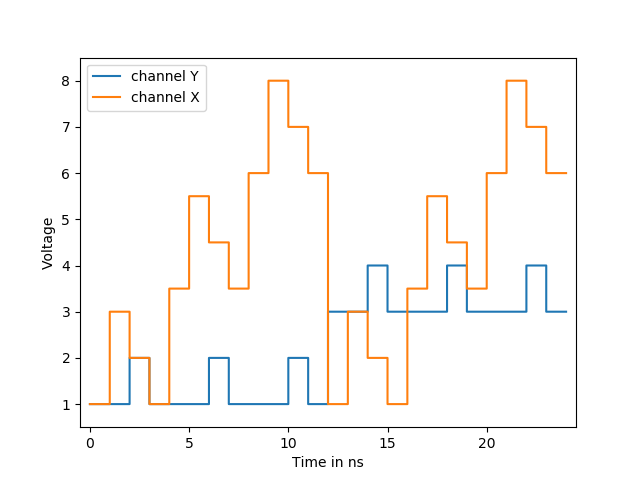

<IPython.core.display.Javascript object>


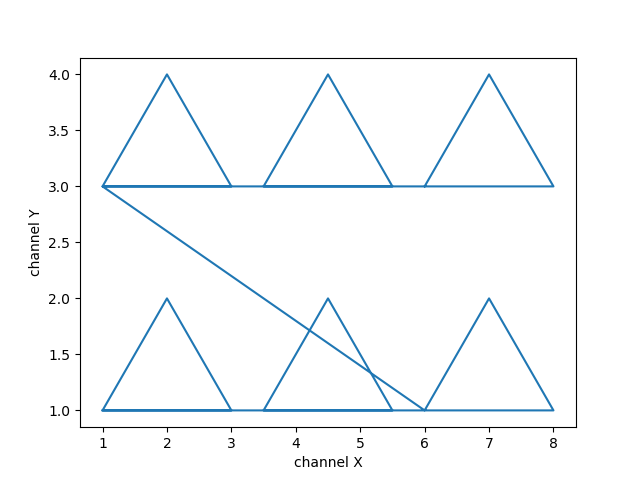

Text(0,0.5,'channel Y')

In [3]:
from qctoolkit.pulses import ForLoopPT

# Loop the mapped pulse in x-direction
xloop_pulse = ForLoopPT(
    body=mapped_pulse,
    loop_index='i_x',
    loop_range='n[0]'
)

# Loop the looped pulse again in y-direction
xyloop_pulse = ForLoopPT(
    body=xloop_pulse,
    loop_index='i_y',
    loop_range='n[1]'
)

print(xyloop_pulse.parameter_names)

# Merge new parameters into old dictionary
params = {
    **params,
    'start': np.array([1, 1]),
    'stop': np.array([6, 3]),
    'n': np.array([3, 2])
}

_ = plot(xyloop_pulse, params, sample_rate=100)

# plot pulse in 2d
sequencer = Sequencer()
sequencer.push(xyloop_pulse, params)
sequence = sequencer.build()
times, voltages = render(sequence, sample_rate=100)

fig, ax = plt.subplots()
ax.plot(voltages['X'], voltages['Y'])
ax.set_xlabel('channel X')
ax.set_ylabel('channel Y')